In [1]:
from dotenv import load_dotenv,find_dotenv
_ = load_dotenv(find_dotenv())

In [2]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4",stream_usage=True)


In [5]:
llm.invoke("Generate a list of user stories for an e-commerce application, with each user story formatted as: 'As a [type of user], I want [goal] so that [reason].' Please return the response as a list (array format).")

AIMessage(content='[\n"As a customer, I want to be able to create an account so that I can keep track of my orders.",\n"As a customer, I want to be able to browse products by category so that I can more easily find what I\'m looking for.",\n"As a customer, I want to be able to search for specific products so that I can find what I need quickly.",\n"As a customer, I want to be able to add products to a cart so that I can purchase multiple items at once.",\n"As a customer, I want to be able to view my cart so that I can verify my orders before checking out.",\n"As a customer, I want to be able to remove items from my cart so that I can manage my potential purchase.",\n"As a customer, I want to have secure payment options so that I can make payments safely.",\n"As a customer, I want to be able to track my order so that I can know when it will arrive.",\n"As a customer, I want to see product reviews so that I can make informed purchasing decisions.",\n"As a customer, I want to be able to l

In [37]:
from typing import Annotated


from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

In [38]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [39]:
graph_builder = StateGraph(State)

In [40]:
@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    print("hi")
    human_response = interrupt({"query": query})
    return human_response["data"]


In [41]:

tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

In [42]:
def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    # assert len(message.tool_calls) <= 1
    return {"messages": [message]}

In [43]:
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [44]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

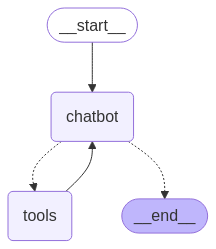

In [45]:
graph

In [49]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_ohnfolPnqBmrDvZRjReJ4W3w)
 Call ID: call_ohnfolPnqBmrDvZRjReJ4W3w
  Args:
    query: Guidance for building an AI agent
hi


In [47]:
snapshot = graph.get_state(config)
snapshot.next

()

In [50]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_ohnfolPnqBmrDvZRjReJ4W3w)
 Call ID: call_ohnfolPnqBmrDvZRjReJ4W3w
  Args:
    query: Guidance for building an AI agent
hi
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

According to expert guidance, you may want to consider using LangGraph to build your AI agent. This platform is reliable and extensible, making it a versatile choice for developing various types of AI agents. However, without knowing the specifics of what you're trying to accomplish, this is a fairly general suggestion.

When building an AI agent, you will want to consider the following steps:

1. **Unders